<a href="https://colab.research.google.com/github/tanaxer01/mov-in-covid/blob/main/cov_predictions_no_sarimax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
!pip install unidecode

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from requests import get
from zipfile import ZipFile
from threading import Thread
from unidecode import unidecode
from datetime import datetime, timedelta

# GITHUB Datasets

## base

In [3]:
datasets = {
  # DP1
  "dp1_contagios": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto1/Covid-19_std.csv",
  # DP7
  "dp7_pcr": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto7/PCR_std.csv",
  # DP20
  "dp20_camas": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto20/NumeroVentiladores_std.csv",
  # DP51
  "dp51_difs": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto51/ISCI_std.csv",
  # DP82
  "dp82_weeks": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto82/ISCI_weeks.csv",
  "dp82_weekends": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto82/ISCI_weekends.csv",
}

if not os.path.exists("./datos"):
  os.mkdir("./datos")

for name, url in datasets.items():
  if not os.path.exists(f"./datos/{name}.csv"):
    with open(f"./datos/{name}.csv", "w") as archivo:
      archivo.write( get(url).content.decode() ) 

## DP1

In [4]:
DataProduct1 = pd.read_csv("./datos/dp1_contagios.csv", parse_dates=["Fecha"])

# Just RM
DataProduct1 = DataProduct1[ (DataProduct1["Codigo region"] == 13) & (DataProduct1["Comuna"] != "Desconocido Metropolitana") ]
# Remove garbage
DataProduct1 = DataProduct1.set_index("Fecha").drop(columns=["Region", "Codigo region"])
DataProduct1['Comuna'] = DataProduct1['Comuna'].apply(lambda x: unidecode(x).lower())

######### ######### ######### ######### ######### ######### ######### ######### #########

## cov_all: Cantidad de contagios acumulativa x comuna(columnas) y fecha(index)
cov_all = DataProduct1.pivot_table(values="Casos confirmados", index="Fecha", columns="Comuna").rename(columns=lambda x: unidecode(x).lower())  
## cov_new: Cantidad de contagios nuevos x comuna(columnas) y fecha(index)
cov_new = cov_all.subtract( cov_all.shift(periods=1, fill_value=0) )
cov_new.head(1)

Comuna,alhue,buin,calera de tango,cerrillos,cerro navia,colina,conchali,curacavi,el bosque,el monte,...,san bernardo,san joaquin,san jose de maipo,san miguel,san pedro,san ramon,santiago,talagante,tiltil,vitacura
Fecha,,,,,,,,,,,,,,,,,,,,,
2020-03-30,0.0,7.0,6.0,0.0,19.0,32.0,14.0,5.0,18.0,0.0,...,32.0,13.0,0.0,25.0,0.0,0.0,127.0,0.0,0.0,83.0


## DP7

In [5]:
DataProduct7 = pd.read_csv("./datos/dp7_pcr.csv", parse_dates=["fecha"])

# Just RM
DataProduct7 = DataProduct7[ DataProduct7['Codigo region'] == 13 ]
DataProduct7 = DataProduct7.set_index("fecha").drop(columns=["Region", "Codigo region", "Poblacion"])

######### ######### ######### ######### ######### ######### ######### ######### #########

# cant_pcr: cantidad de pcr realizados por dia a nivel regional.
cant_pcr = DataProduct7["numero"]
cant_pcr.head(5)

fecha
2020-04-09    5383.0
2020-04-10    3185.0
2020-04-11    2105.0
2020-04-12    3861.0
2020-04-13    1850.0
Name: numero, dtype: float64

## DP20

In [6]:
DataProduct20 = pd.read_csv("./datos/dp20_camas.csv", parse_dates=["fecha"])
DataProduct20 = DataProduct20.set_index("fecha")

######### ######### ######### ######### ######### ######### ######### ######### #########

# camas_criticas: Dataset que contiene el numero de camas criticas disp y ocupadas a nivel nacional.
camas_criticas = pd.DataFrame({ 
    "totales": DataProduct20[ DataProduct20.Ventiladores == "total" ]["numero"],
    "disponibles": DataProduct20[ DataProduct20.Ventiladores == "disponibles" ]["numero"],
    "ocupados": DataProduct20[ DataProduct20.Ventiladores == "ocupados" ]["numero"]
})

camas_criticas.head(3)

,totales,disponibles,ocupados
fecha,,,
2020-04-14,1550,564,986
2020-04-15,1563,577,986
2020-04-16,1582,569,1013


## DP51

In [7]:
DataProduct51 = pd.read_csv("./datos/dp51_difs.csv", parse_dates=["Fecha"])
DataProduct51 = DataProduct51[ DataProduct51['Codigo region'] == 13 ].drop(columns=['Region', 'Codigo region', 'Cartodb id'])

parse_diff = lambda x: (100 + sum([ int(i)  for i in x[1:-2].replace('%','').split(",") ])/2)/ 100

DataProduct51['Comuna'] = DataProduct51['Comuna'].apply(lambda x: unidecode(x).lower()) 

DataProduct51['Salida']  = DataProduct51['Dif salida'].map(parse_diff)
DataProduct51['Entrada'] = DataProduct51['Dif entrada'].map(parse_diff)

######### ######### ######### ######### ######### ######### ######### ######### #########

# IM_salida: Valor promedio de la variación porcentual de salida entre las manzanas censales de cada comuna.
IM_salida = DataProduct51.groupby(['Fecha', 'Comuna'], as_index=False)["Salida"].mean()
IM_salida = IM_salida.pivot_table(values="Salida", columns="Comuna", index="Fecha")
# IM_entrada: Valor promedio de la variación porcentual de entrada entre las manzanas censales de cada comuna.
IM_entrada = DataProduct51.groupby(['Fecha', 'Comuna'], as_index=False)["Entrada"].mean()
IM_entrada = IM_entrada.pivot_table(values="Entrada", columns="Comuna", index="Fecha")

IM_salida.head(2)

Comuna,alhue,buin,calera de tango,cerrillos,cerro navia,colina,conchali,curacavi,el bosque,el monte,...,renca,san bernardo,san joaquin,san jose de maipo,san miguel,san ramon,santiago,talagante,tiltil,vitacura
Fecha,,,,,,,,,,,,,,,,,,,,,
2020-03-02,0.995,1.072143,1.265,1.149286,1.175,1.2875,1.140385,1.29875,1.265,1.085,...,1.1975,1.173676,1.139643,0.995,1.345417,1.031818,1.101744,1.157,1.319,1.026154
2020-03-09,0.995,1.072143,1.265,1.149286,1.175,1.2875,1.140385,1.29875,1.265,1.085,...,1.1975,1.173676,1.139643,0.995,1.332500,1.031818,1.101744,1.157,1.319,1.026154


## DP82

In [8]:
DataProduct82a = pd.read_csv('./datos/dp82_weeks.csv', parse_dates=["fecha_inicio"])
DataProduct82b = pd.read_csv('./datos/dp82_weekends.csv', parse_dates=["fecha_inicio"])

DataProduct82 = pd.concat([DataProduct82a, DataProduct82b]).sort_values("fecha_inicio")

DataProduct82 = DataProduct82[ DataProduct82['region'] == 13 ].drop(columns=['region'])
DataProduct82["paso"] = DataProduct82["paso"].fillna(method="ffill")
DataProduct82["nom_comuna"] = DataProduct82["nom_comuna"].apply(lambda x: unidecode(x).lower())

# ######### ######### ######### ######### ######### ######### ######### ######### #########

# paso_a_paso: Etapas del paso a paso de cada comuna por dia.
paso_a_paso = DataProduct82.pivot_table(values='paso', index='fecha_inicio', columns='nom_comuna')

# # var_salidas: Variación del IM de salida de cada comuna por dia.
var_salidas = DataProduct82.pivot_table(values="var_salidas", index="fecha_inicio", columns="nom_comuna")

[ i for i in DataProduct82["nom_comuna"].drop_duplicates() if 'san' in i]

['santiago',
 'san joaquin',
 'san miguel',
 'san bernardo',
 'san jose de maipo',
 'san ramon']

In [9]:
df = pd.concat([var_salidas.santiago, paso_a_paso.santiago], axis=1).dropna()



df

,santiago,santiago
fecha_inicio,,
2020-03-02,0.990904,0.0
2020-03-07,1.007680,0.0
2020-03-09,1.003012,0.0
2020-03-14,0.990482,0.0
2020-03-16,0.807805,0.0
...,...,...
2022-07-02,1.067662,4.0
2022-07-04,1.000951,4.0
2022-07-09,1.060588,4.0


# DRIVE Dataset (No se utiliza)

In [ ]:
DATA_DIR = "drive/MyDrive/Datasets/"
FILES = {
  "01": "01_enero_18_24.csv",
  "02": "02_febrero_08_14.csv",
  "03": "03_marzo_15_21.csv",
  # "04": "04_abril_12_18.csv",
  "05": "05_mayo_10_16.csv",
  "06": "06_junio_07_13.csv",
  "07": "07_julio_05_11.csv"
}

PROCESS = True 

In [ ]:
import dask.dataframe as dd

principal_cols = ['netapa', "tiempo_subida", "comuna_subida", "comuna_bajada" ]
final = pd.DataFrame()
for nombre, archivo in FILES.items():
  print( nombre )
  mes = dd.read_csv(DATA_DIR + archivo, usecols=principal_cols).dropna()
  # FILTER
  filtro = (mes.netapa == 1) & (mes.tiempo_subida.str[11:13].isin(["06", "07", "08"]))
  mes = mes[filtro]

  # CONVERT
  mes["comuna_subida"] = mes["comuna_subida"].apply(lambda x: unidecode(x.lower()), meta=('comuna_subida', 'object'))
  mes["comuna_bajada"] = mes["comuna_bajada"].apply(lambda x: unidecode(x.lower()), meta=('comuna_bajada', 'object'))

  mes["tiempo_subida"] = mes["tiempo_subida"].apply(lambda x: x[5:10], meta=('tiempo_subida', 'object'))

  # GROUPBY
  dia = mes.groupby([ "tiempo_subida", "comuna_subida", "comuna_bajada" ])['netapa'].count()
  # display(dia.dask)
  final = pd.concat([final, dia.compute(num_workers = 4).reset_index()])

01
02
03
05
06
07


In [ ]:
# mes = dia
# mes["tiempo_subida"] = mes["tiempo_subida"].apply(lambda x: str(x)+"/01")  

# mes[ mes.tiempo_subida.isin(["06", "07", "08", "09"]) ]
# mes
#final[ (final.tiempo_subida.str.contains("01-18")) ]["netapa"].sum()
final

,tiempo_subida,comuna_subida,comuna_bajada,netapa
0,01-18,cerrillos,cerrillos,1148
1,01-18,cerrillos,estacion central,1275
2,01-18,cerrillos,independencia,25
3,01-18,cerrillos,la cisterna,151
4,01-18,cerrillos,la florida,57
...,...,...,...,...
6351,07-11,san bernardo,independencia,2
6352,07-11,san bernardo,la florida,1
6353,07-11,san miguel,huechuraba,2
6354,07-11,san ramon,san joaquin,1


### Calculo Población flotante - Threads

In [ ]:
import concurrent.futures
import logging

def process_file(input_path, output_path):
  logging.debug(f"[+] processing {input_path}")
  # Datos principales
  principal_cols = [ 'netapa', 'tiempo_subida', 'comuna_subida', 'comuna_bajada' ] 
  # Datos segundarios (En vola usarlos)
  secondary_cols = [ 'dist_eucl_paraderos', 'periodosubida']

  date = lambda x: x.tiempo_subida[5:10]

  with ZipFile(input_path) as zip:
    mes = pd.read_csv(zip.open(zip.namelist()[0]), usecols=principal_cols, na_values="-", chunksize=100000, 
                      convert = { 'comuna_subida':},
                      dtype   = { 'netapa': "int16", "tiempo_subida": "object", "comuna_subida": "category", "comuna_bajada": "category" })

  rows = pd.DataFrame(columns=["tiempo_subida", "comuna_subida", "comuna_bajada", "netapa"])
  for num, chunk in enumerate(mes):
    temp = chunk["tiempo_subida"].str[10:13].astype(int)
    chunk["tiempo_subida"] = chunk.tiempo_subida.apply(lambda x: x[5:10])
    chunk = chunk[ (chunk.netapa == 1) & (temp < 10) & (temp > 5) ]

    suma = chunk.groupby(["tiempo_subida", "comuna_subida", "comuna_bajada"], as_index=False).count()
    rows = rows.append(suma, ignore_index=True)

  logging.debug(f"[+] ended {input_path}")
  rows = rows.rename(columns={"netapa": "viajes"})
  rows.to_csv(output_path, index=False)
  
  


# if PROCESS:
#   with concurrent.futures.ThreadPoolExecutor(max_workers = 7) as executor:
#     #futures = [ executor.submit(process_file, DATA_DIR+FILES["enero"], f"./calcs/enero_nums.csv") ]
#     futures = [ executor.submit(process_file, DATA_DIR+j, DATA_DIR+f"calcs/{i}_nums.csv") for i, j in FILES.items() ] 
  
#     done, not_done = concurrent.futures.wait(futures, return_when=concurrent.futures.ALL_COMPLETED) 
#     print(done)
process_file( DATA_DIR+FILES["enero"], "./enero_nums.csv")

### Importación numeros

In [ ]:
import os

viajes = pd.DataFrame(columns=["tiempo_subida", "comuna_subida", "comuna_bajada", "viajes"])
for i in os.listdir(DATA_DIR + "calcs"):
  curr = pd.read_csv(DATA_DIR+"calcs/"+i)
  
  mes  = curr.tiempo_subida.iloc[0][:2]

  # FIX WRONGLY WRITTEN COMMUNES
  curr["comuna_subida"] = curr["comuna_subida"].map(unidecode)
  curr["comuna_bajada"] = curr["comuna_bajada"].map(unidecode)

  # GROUP BY date, source & destiny
  curr = curr.groupby(["tiempo_subida", "comuna_subida", "comuna_bajada"], as_index=False).sum()
  viajes = viajes.append( curr )

# pob_flot = viajes[viajes["comuna_subida"] == "santiago"].groupby([ "tiempo_subida" ], as_index=False)["viajes"].sum()
# pob_flot["tiempo_subida"] = suma["tiempo_subida"].apply(lambda x: datetime.strptime("2021-"+x, "%Y-%m-%d"))

# suma
viajes

,tiempo_subida,comuna_subida,comuna_bajada,viajes
0,04-12,CERRILLOS,CERRILLOS,1096
1,04-12,CERRILLOS,CONCHALI,12
2,04-12,CERRILLOS,EL BOSQUE,4
3,04-12,CERRILLOS,ESTACION CENTRAL,1096
4,04-12,CERRILLOS,INDEPENDENCIA,20
...,...,...,...,...
6399,07-11,VITACURA,QUINTA NORMAL,26
6400,07-11,VITACURA,RECOLETA,24
6401,07-11,VITACURA,SAN RAMON,7
6402,07-11,VITACURA,SANTIAGO,114


# Merge Data

In [123]:
comunas = list(cov_new.drop(columns=['santiago']).columns)
comunas.pop(46) # san pedro

movi = { "movi-"+i: var_salidas[i].shift(periods=1) for i in comunas + ["santiago"] }
mov2 = { "mov2-"+i: var_salidas[i].shift(periods=3) for i in comunas + ["santiago"] }
paso = { "paso-"+i: paso_a_paso[i].shift(periods=1) for i in comunas + ["santiago"] }
pas2 = { "pas2-"+i: paso_a_paso[i].shift(periods=3) for i in comunas + ["santiago"] }
covd = { "covd-"+i: cov_new[i].shift()     for i in comunas }
otro = { "pcrs_realizados": cant_pcr, "covd-santiago": cov_new.santiago }

# all_data = pd.DataFrame({**movi, **mov2, **covd, **paso, **otro})
all_data = pd.DataFrame({**movi, **mov2, **covd, **paso, **pas2, **otro}).iloc[3:]

In [124]:
all_data = all_data.interpolate(limit=3)
all_data = all_data.dropna()

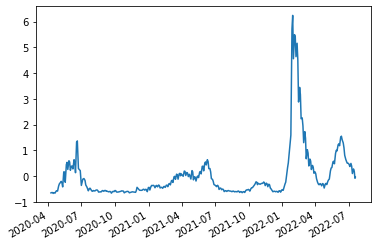

In [128]:
all_data = all_data.dropna()
all_data = (all_data - all_data.mean())/all_data.std()

all_data['covd-santiago'].plot()

# Regresión Lineal

In [81]:
from sklearn.metrics         import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing   import StandardScaler
from sklearn.linear_model    import LinearRegression 
from sklearn.neural_network  import MLPRegressor

In [129]:
X = all_data.drop(columns=["covd-santiago"])
y = all_data["covd-santiago"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.333, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6,random_state=42)

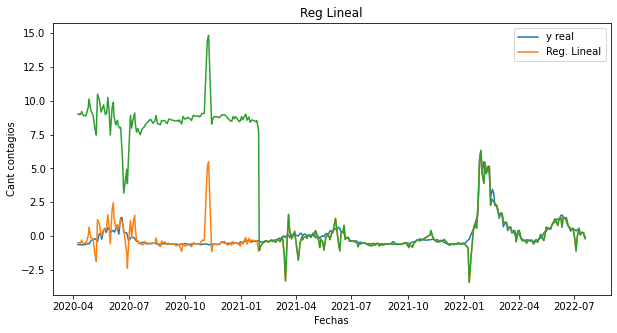

In [131]:
reg1 = LinearRegression(fit_intercept=False)
reg1.fit(X_train, y_train)

y_pred1 = reg1.predict(X_test)

A = X_test.copy()

A["covd-cerrillos"].loc[:'2021-01-30'] = X_test["covd-cerrillos"].max()
A["covd-lo prado"].loc[:'2021-01-30'] = X_test["covd-lo prado"].max()
A["covd-maria pinto"].loc[:'2021-01-30'] = X_test["covd-maria pinto"].max()

y_pred3 = reg1.predict(A)


fig, ax = plt.subplots(figsize=(10,5))
ax.plot(y)

plt.plot(pd.Series(y_pred1, index=y_test.index).sort_index())
plt.plot(pd.Series(y_pred3, index=y_test.index).sort_index())

ax.set_title("Reg Lineal")
ax.set_xlabel("Fechas")
ax.set_ylabel("Cant contagios")
ax.legend(['y real', 'Reg. Lineal'])

plt.show()

In [134]:
print( f'R2 Regressor  = {r2_score(y_test, y_pred1):.2f}' )
print( f'MAE Regressor = {mean_absolute_error(y_test, y_pred1):.2f}' )
print( f'MSE Regressor = {mean_squared_error(y_test, y_pred1):.2f}' )

scores1 = cross_val_score(reg1, X_test, y_test, cv=10)
print("cross_val: %0.2f accuracy with a standard deviation of %0.2f" % (scores1.mean(), scores1.std()))

R2 Regressor  = 0.29
MAE Regressor = 0.38
MSE Regressor = 0.72
cross_val: 0.90 accuracy with a standard deviation of 0.07


# MLP

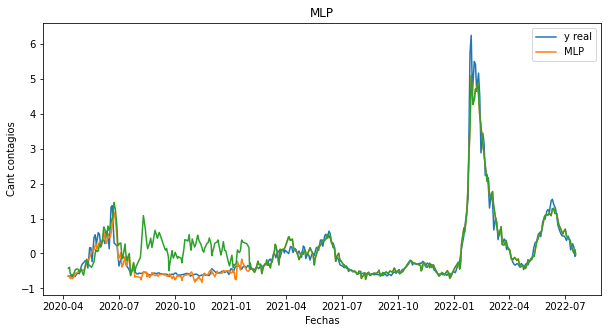

In [132]:
reg2 = MLPRegressor(random_state=1, max_iter=500)
reg2.fit(X_train, y_train)

y_pred2 = reg2.predict(X_test)

A = X_test.copy()

A["covd-cerrillos"].loc[:'2021-01-30'] = X_test["covd-cerrillos"].max()
A["covd-lo prado"].loc[:'2021-01-30'] = X_test["covd-lo prado"].max()
A["covd-maria pinto"].loc[:'2021-01-30'] = X_test["covd-maria pinto"].max()

y_pred4 = reg2.predict(A)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(y)

plt.plot(pd.Series(y_pred2, index=y_test.index).sort_index())
plt.plot(pd.Series(y_pred4, index=y_test.index).sort_index())

ax.set_title("MLP")
ax.set_xlabel("Fechas")
ax.set_ylabel("Cant contagios")
ax.legend(['y real', 'MLP'])

plt.show()

In [133]:
print( f'R2 Regressor  = {r2_score(y_test, y_pred2):.2f}' )
print( f'MAE Regressor = {mean_absolute_error(y_test, y_pred2):.2f}' )
print( f'MSE Regressor = {mean_squared_error(y_test, y_pred2):.2f}' )

scores2 = cross_val_score(reg2, X_test, y_test, cv=10)
print("cross_val: %0.2f accuracy with a standard deviation of %0.2f" % (scores2.mean(), scores2.std()))

R2 Regressor  = 0.95
MAE Regressor = 0.13
MSE Regressor = 0.05
cross_val: 0.93 accuracy with a standard deviation of 0.05
